In [1]:
# ipython
%matplotlib inline

from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("white")
import glob
import json
import os
import sys
import json
import os
import sys
import multiprocessing
pool = multiprocessing.Pool(multiprocessing.cpu_count())

os.makedirs("figures", exist_ok=True)
def save_fig(ax, fn):
    ax.get_figure().savefig(f"figures/{fn}.pdf", bbox_inches="tight")

In [2]:
import sqlite3
conn = sqlite3.connect('ratings.db')

tables = ["info", "ratings", "user_playlist"]

df = pd.read_sql_query("SELECT * from ratings", conn)
dinfo = pd.read_sql_query("SELECT * from info", conn)
dpl = pd.read_sql_query("SELECT * from user_playlist", conn)


d(dinfo.head())
d(dpl.head())
d(df.head())
print(len(df))

,user_ID,info_json
0,1,"{""userAgeRange"": ""30 to 39"", ""userGender"": ""Ma..."
1,4,"{""userAgeRange"": ""30 to 39"", ""userGender"": ""Ma..."
2,5,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Ma..."
3,6,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Ma..."
4,62,"{""userAgeRange"": ""25 to 29"", ""userGender"": ""Fe..."


,user_ID,playlist,timestamp
0,1,"[688, 309, 152, 1161, 1011, 1267, 757, 441, 11...",2020-03-27 13:50:53 566703
1,2,"[956, 589, 1082, 650, 657, 807, 596, 970, 1023...",2020-03-27 13:35:00 968899
2,3,"[468, 313, 1210, 1287, 996, 271, 1149, 439, 81...",2020-03-27 14:14:14 643751
3,4,"[476, 912, 42, 1258, 732, 308, 1155, 1079, 410...",2020-03-27 14:55:32 195248
4,5,"[358, 1385, 786, 777, 902, 644, 1002, 1183, 14...",2020-03-27 16:06:05 479548


,user_ID,stimuli_ID,stimuli_file,rating_type,rating,timestamp
0,1,-1,,user_registered,-1,2020-03-27 13:50:53 566942
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894


25325


In [3]:
users_who_rated = set(pd.read_sql_query("select distinct(user_id) from ratings where rating <> -1", conn)["user_ID"].values)
print(len(users_who_rated))
print(users_who_rated)

238
{1, 4, 5, 6, 7, 62, 65, 82, 89, 106, 110, 111, 112, 113, 114, 115, 116, 117, 118, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 133, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 190, 191, 192, 193, 194, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 241, 242, 243, 244, 245, 246, 249, 250, 251, 252, 253, 255, 256, 257, 259, 260, 261, 263, 265, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 308, 309, 310, 312, 313, 314, 316, 317, 319, 320, 321, 322, 323, 324, 326, 327, 328, 330, 331,

In [4]:
import matplotlib.pyplot as plt

def extract_info(x):
    return pd.Series(json.loads(x))

dinfo["rated"] = dinfo["user_ID"].apply(lambda x: x in users_who_rated)
dinfo = dinfo[dinfo["rated"]] 

di = pd.DataFrame(dinfo["info_json"].apply(extract_info))
di = di[di.columns.difference(["userGender"])]


def estimate_os(x):
    if "Windows" in x:
        return "Win"
    if "Apple" in x or "Mac" in x:
        return "MacOS"
    if "Linux" in x:
        return "Linux"
    return "other"

di["os"] = di["browser_agent"].apply(estimate_os)

di["screen_size"] = di["screen_size"].apply(lambda x: -1 if x == "" else int(x.split("x")[1]))

print(di.head())

                                       browser_agent  screen_size  \
0  Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...          722   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          722   
2  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...         1298   
3  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          937   
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...          722   

  userAgeRange userComputerType userEyeQuality              userRoomQuality  \
0     30 to 39           Laptop        Good(4)  Some Noise and Distractions   
1     30 to 39           Laptop   Excellent(5)        Alone in a Quiet Room   
2     25 to 29          Desktop   Excellent(5)        Alone in a Quiet Room   
3     25 to 29          Desktop   Excellent(5)        Alone in a Quiet Room   
4     25 to 29           Laptop        Good(4)        Alone in a Quiet Room   

      os  
0  MacOS  
1    Win  
2    Win  
3    Win  
4    Win  


237


,browser_agent,screen_size,userAgeRange,userComputerType,userEyeQuality,userRoomQuality,os
0,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,722,30 to 39,Laptop,Good(4),Some Noise and Distractions,MacOS
1,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,722,30 to 39,Laptop,Excellent(5),Alone in a Quiet Room,Win
2,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1298,25 to 29,Desktop,Excellent(5),Alone in a Quiet Room,Win
3,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,937,25 to 29,Desktop,Excellent(5),Alone in a Quiet Room,Win
4,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,722,25 to 29,Laptop,Good(4),Alone in a Quiet Room,Win


browser_agent
os
screen_size
userAgeRange
userComputerType
userEyeQuality
userRoomQuality


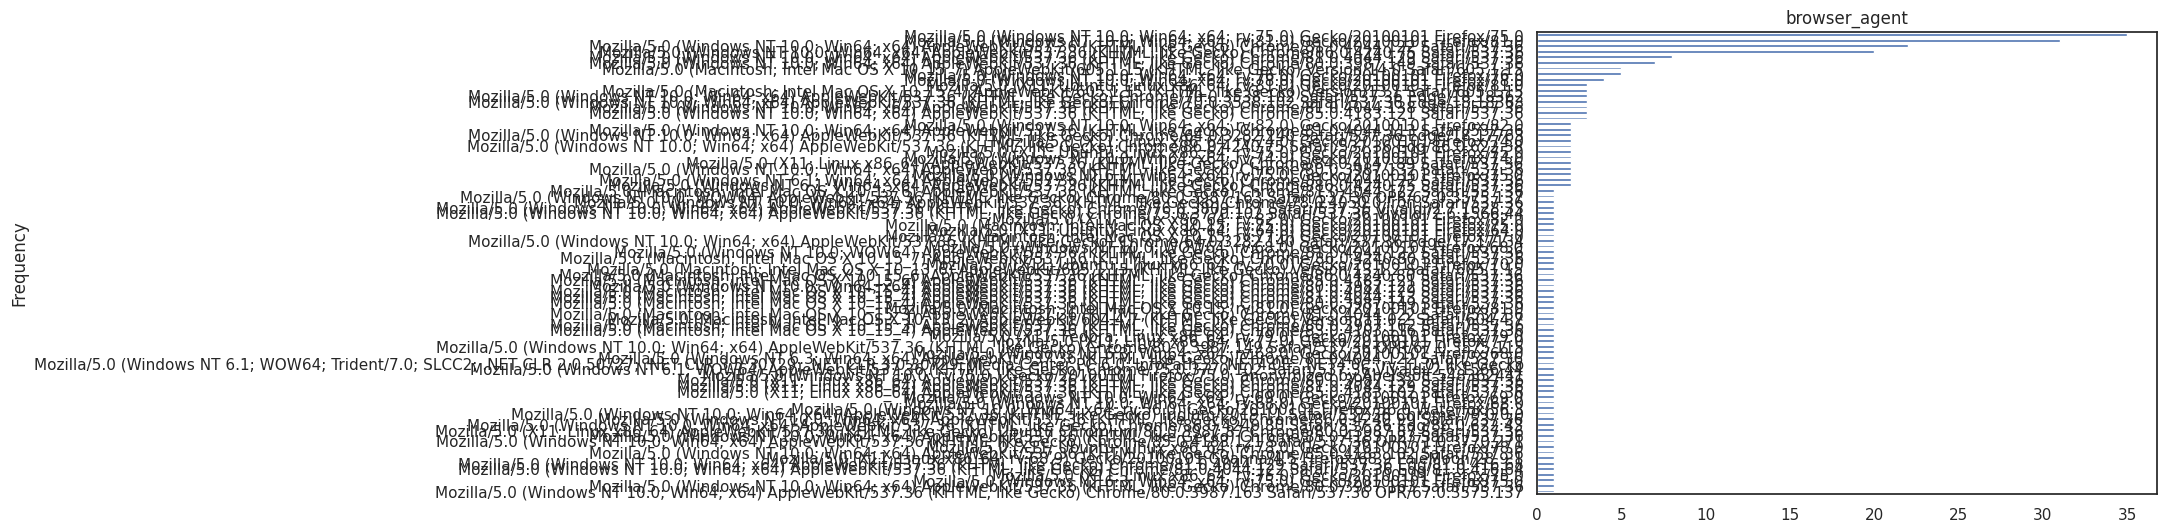

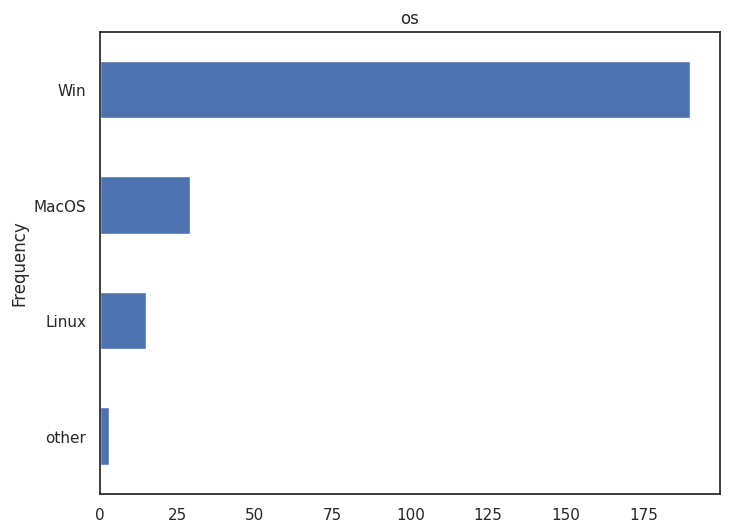

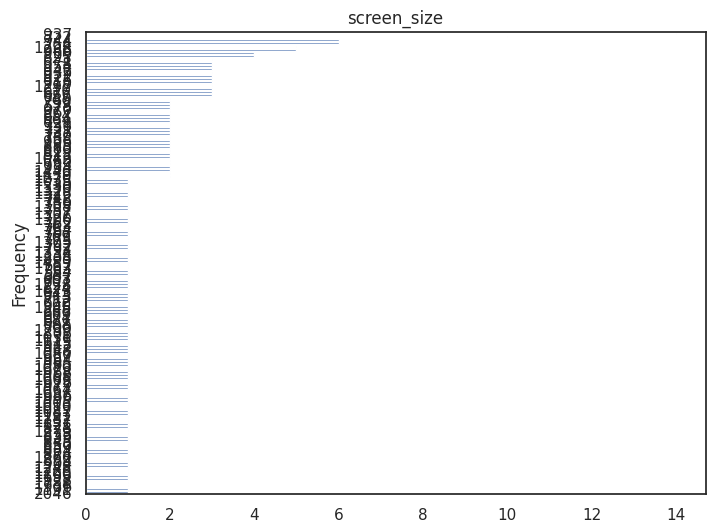

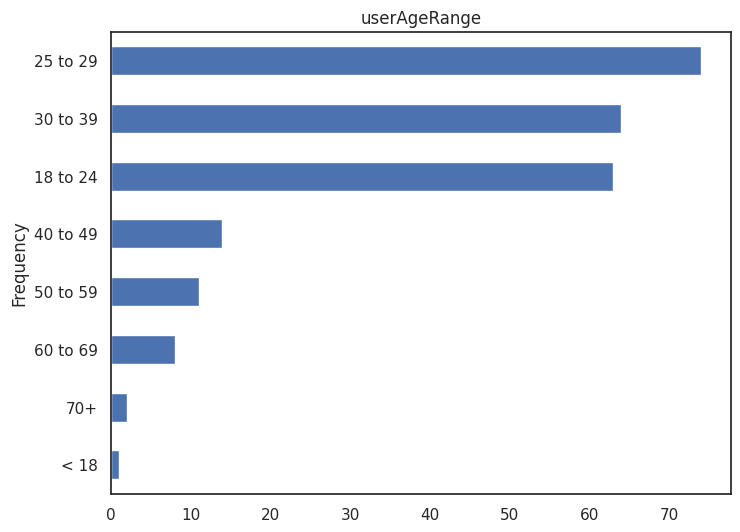

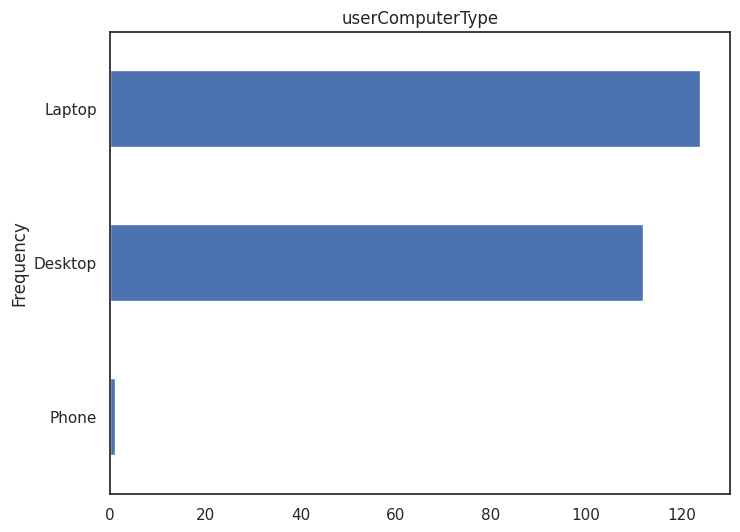

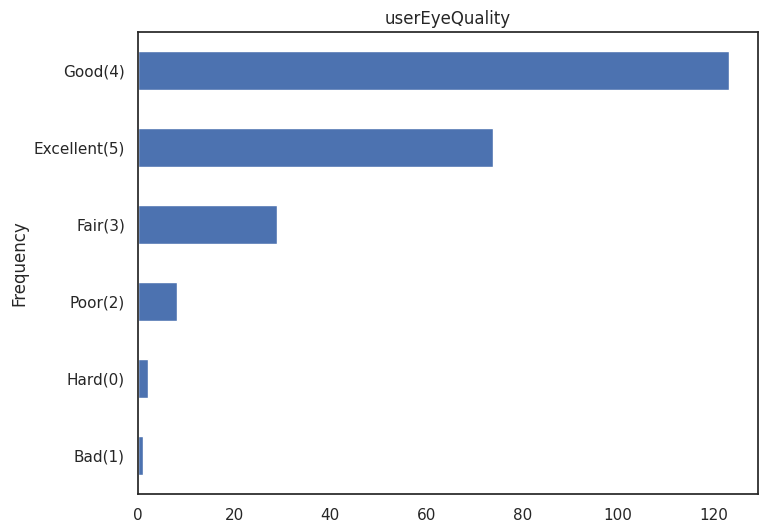

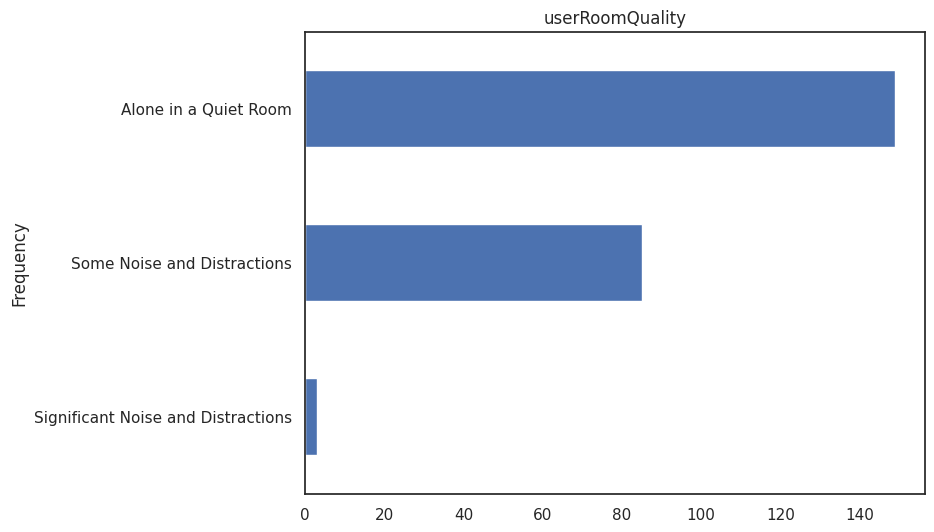

In [5]:

print(len(di))
d(di.head())
di["c"] = 1
for c in di.columns.difference(["c"]):
    print(c)
    gg = di.groupby(by=c).count().reset_index()[[c, "c"]]
    gg = gg.sort_values(by="c")
    ax = gg.plot(x=c, y="c", kind="barh", legend=False, figsize=(8,6))
    ax.set_title(c)
    ax.set_ylabel("Frequency")
    save_fig(ax, "user_" + c)

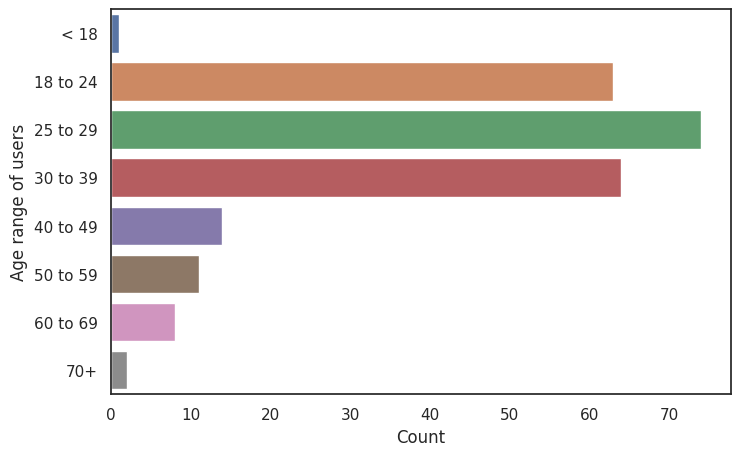

In [6]:
c = "userAgeRange"
sns.set(rc={'figure.figsize':(8,5)})

sns.set_style("white")
order = [ 
    '< 18',
    '18 to 24' , 
    '25 to 29',
    '30 to 39',
    '40 to 49', 
    '50 to 59',
    '60 to 69',
    '70+', ]
ax = sns.countplot(y=c, data=di, order=order)
ax.set_ylabel("Age range of users")
ax.set_xlabel("Count")
save_fig(ax, "user_" + c)

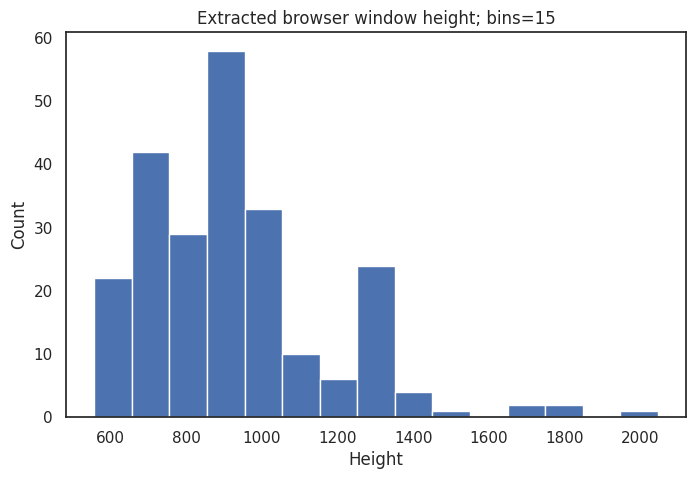

In [7]:
ddd = di[di["screen_size"]> 100]

ax = ddd["screen_size"].plot(kind="hist", bins=15,figsize=(8,5))
ax.set_xlabel("Height")
ax.set_title(f"Extracted browser window height; bins=15")
ax.set_ylabel("Count")
save_fig(ax, "user_windowheight")

,user_ID,stimuli_ID,stimuli_file,rating_type,rating,timestamp
0,1,-1,,user_registered,-1,2020-03-27 13:50:53 566942
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894


25325 24782 543


/tmp/ipykernel_317857/920517994.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr["c"] = 1


<AxesSubplot: xlabel='c', ylabel='Count'>

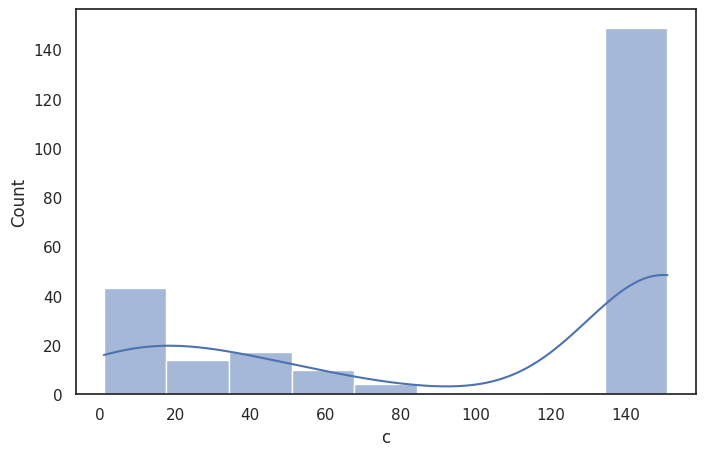

In [8]:
d(df.head())
df["rating"] = df["rating"].copy().astype(np.int32)
# select pure ratings
dr = df[df["rating"] > 0]
print(
    len(df),
    len(dr),
    len(df) - len(dr)
)

dr["c"] = 1
sns.histplot(dr.groupby(by="user_ID").count().reset_index()["c"], kde=True)

In [9]:
h = {}
for x in dr.groupby(by=["stimuli_ID"]).count().reset_index()["c"].values:
    h[x] = h.get(x, 0) + 1
print(h)
print(h[10], h[11])

mm = 0
for i in range(10, 100):
    mm += h.get(i, 0)
print(mm)


mm = 0
for i in range(0, 10):
    mm += h.get(i, 0)
print(mm)

print(h.get(1, 0))
print(h.get(1, 0))

{13: 113, 20: 89, 22: 63, 18: 135, 23: 45, 16: 147, 14: 124, 10: 35, 12: 82, 15: 151, 9: 23, 21: 84, 25: 13, 11: 43, 19: 106, 17: 155, 8: 15, 33: 1, 24: 24, 26: 11, 27: 5, 32: 2, 5: 1, 28: 7, 7: 6, 30: 4}
35 43
1439
45
0
0


In [10]:
avg = dr.groupby(by=["stimuli_file"]).count().reset_index()["c"].mean()
print(avg)

16.69946091644205


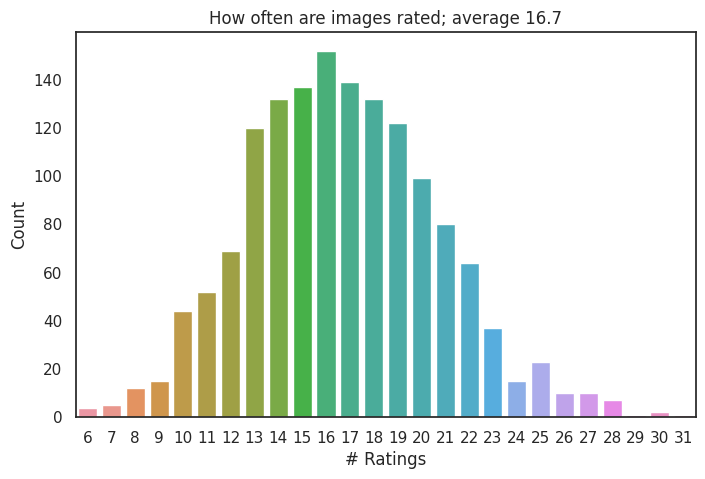

In [11]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("white")

ax = sns.countplot(x=dr.groupby(by=["stimuli_file"]).count().reset_index()["c"])
ax.set_xlabel("# Ratings")
ax.set_ylabel("Count")
ax.set_title(f"How often are images rated; average {avg.round(1)}")
save_fig(ax, "how_often_rated")

In [12]:

x = 0
for i in range(10, 100):
    x+= h.get(i,0)
print("patches with >= 10 raters:", x)

patches with >= 10 raters: 1439


In [13]:
x = 0
for i in range(0, 10):
    x+= h.get(i,0)
print("patches with < 10 rater:", x)

patches with < 10 rater: 45


/tmp/ipykernel_317857/880273120.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax = sns.histplot(dr.groupby(by=["stimuli_ID"]).mean().reset_index()["rating"], bins=12, kde=True)


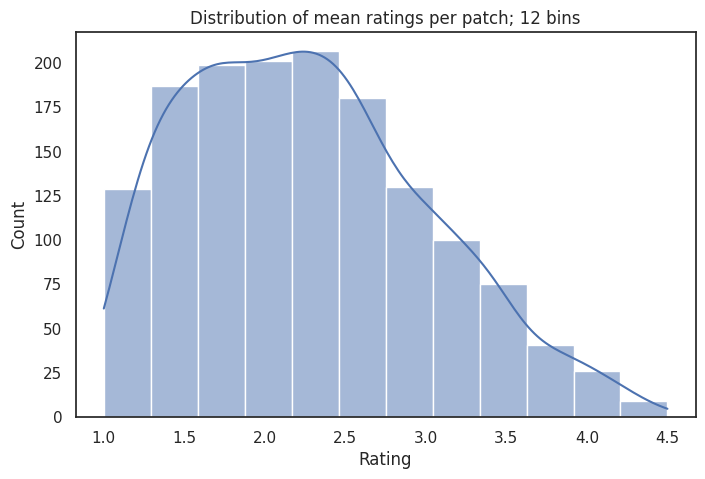

In [14]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("white")
ax = sns.histplot(dr.groupby(by=["stimuli_ID"]).mean().reset_index()["rating"], bins=12, kde=True)

ax.set_title("Distribution of mean ratings per patch; 12 bins")
ax.set_ylabel("Count")
ax.set_xlabel("Rating")

save_fig(ax, "dist_rating_patches")

In [15]:
dmos = pd.read_csv("../test_1/mos_ci.csv")
d(dmos.head())
print(len(dmos))
dr["image_name"] = dr["stimuli_file"].apply(lambda x: "_".join(os.path.basename(x).split("_")[0:-1])).copy()

dmean_r = dr.groupby(by="image_name").mean().reset_index()[["image_name", "rating"]]
dmean_r = dmean_r.rename(columns={"rating": "mean_crowd"})

print(len(dmean_r), len(dr))

d(dmean_r.head())

dstd_r = dr.groupby(by="image_name").std().reset_index()[["image_name", "rating"]]
dstd_r = dstd_r.rename(columns={"rating": "std_crowd"})

dmerged = pd.merge(
    dmos, 
    pd.merge(dmean_r, dstd_r)
)
print(len(dmerged))
d(dmerged.head())

,image_name,mos,ci,std
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,0.601585
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,0.601585
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,0.478091


371
371 24782


/tmp/ipykernel_317857/1222643788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr["image_name"] = dr["stimuli_file"].apply(lambda x: "_".join(os.path.basename(x).split("_")[0:-1])).copy()
/tmp/ipykernel_317857/1222643788.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dmean_r = dr.groupby(by="image_name").mean().reset_index()[["image_name", "rating"]]


,image_name,mean_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,2.763636
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.661765
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.406780
3,BennuProRes4444.mov_1frame_crf_13_height_0304,1.945946
4,BennuProRes4444.mov_1frame_crf_21_height_0320,1.689655


371


/tmp/ipykernel_317857/1222643788.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dstd_r = dr.groupby(by="image_name").std().reset_index()[["image_name", "rating"]]


,image_name,mos,ci,std,mean_crowd,std_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424,2.763636,0.980620
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881,2.661765,0.821544
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,0.601585,2.406780,0.790431
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,0.601585,1.945946,0.719435
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,0.478091,1.689655,0.627076


/tmp/ipykernel_317857/1920671141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr["patch"] = dr["stimuli_file"].apply(lambda x: x.split("_")[-1].split(".")[0])
/tmp/ipykernel_317857/1920671141.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dgg = pd.merge(g, dmos).groupby(by="image_name").mean()
/tmp/ipykernel_317857/1920671141.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be va

0.96

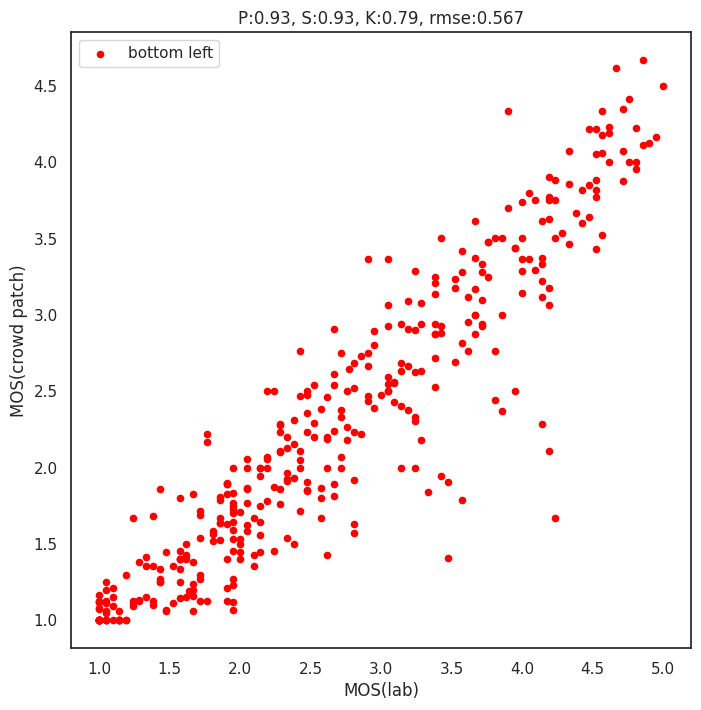

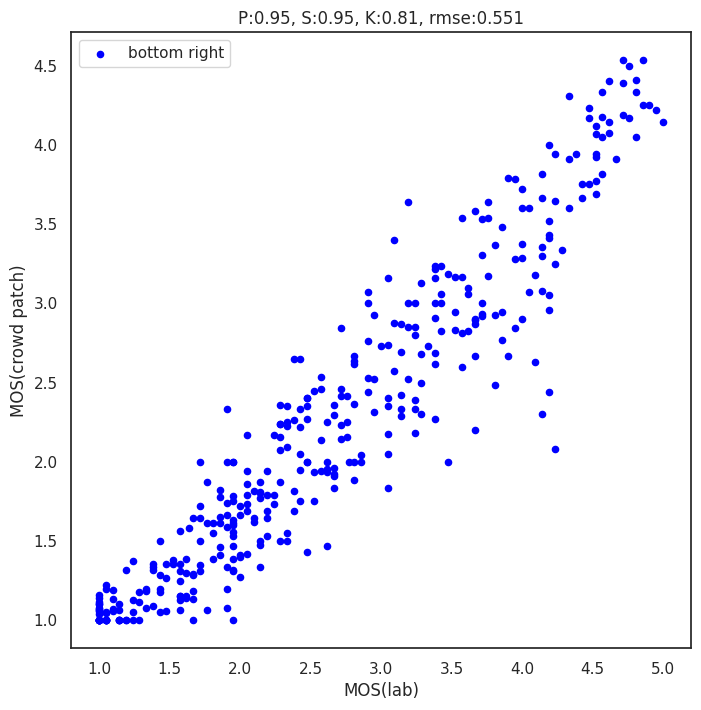

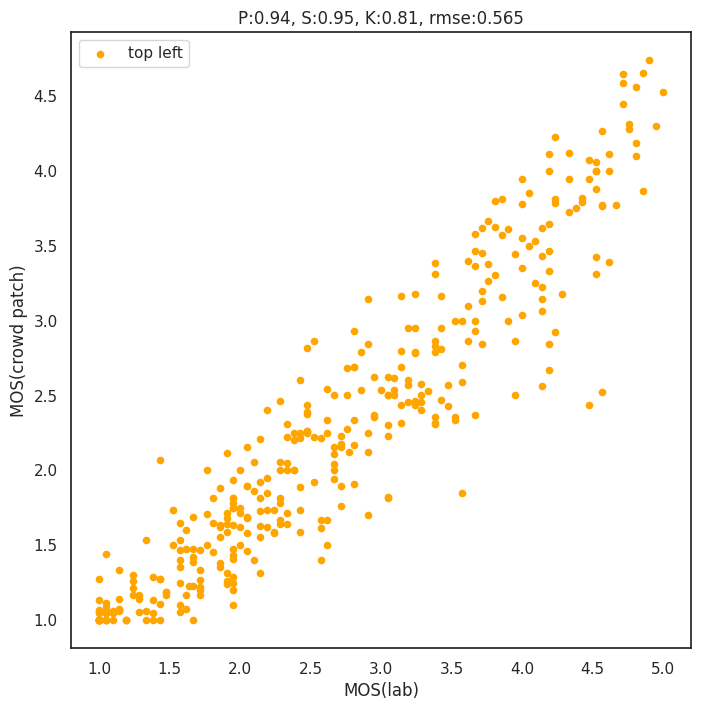

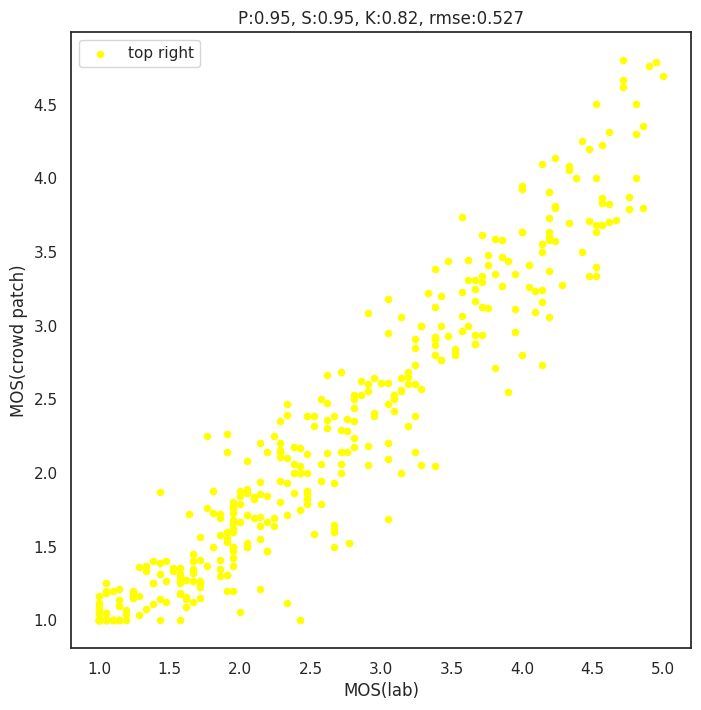

In [16]:
dr["patch"] = dr["stimuli_file"].apply(lambda x: x.split("_")[-1].split(".")[0])
dr = dr.rename(columns={
    "rating": "crowd"
})

#d(dr.head())
cmap = {
    "bl": "red", 
    "br": "blue", 
    "tl": "orange", 
    "tr": "yellow"
}
ax = None
label_map = {
    "bl": "bottom left", 
    "br": "bottom right", 
    "tl": "top left", 
    "tr": "top right"
}
sns.set_style("white")
vvv = []
corrs = []
for i, g in dr.groupby(by="patch"):
    dgg = pd.merge(g, dmos).groupby(by="image_name").mean()
    #print(i)
    #print(len(dgg))
    #d(dgg.head())
    rmse = ((dgg["mos"] - dgg["crowd"]) ** 2).mean() ** .5 
    corr = "P:{}, S:{}, K:{}, rmse:{}".format(
        dgg[["mos", "crowd"]].corr(method="pearson")["mos"][1].round(2),
        dgg[["mos", "crowd"]].corr(method="spearman")["mos"][1].round(2),
        dgg[["mos", "crowd"]].corr(method="kendall")["mos"][1].round(2),
        rmse.round(3)
    )

    ax = dgg.plot(x="mos", y="crowd", kind="scatter", figsize=(8,8), title=corr, c=cmap[i], label=label_map[i])
    ax.set_xlabel("MOS(lab)")
    ax.set_ylabel("MOS(crowd patch)")
    vvv.append(dgg.copy())
    
    corrs.append(
        {
            "patch": label_map[i],
            "pearson": dgg[["mos", "crowd"]].corr(method="pearson")["mos"][1],
            "spearman": dgg[["mos", "crowd"]].corr(method="spearman")["mos"][1],
            "kendall": dgg[["mos", "crowd"]].corr(method="kendall")["mos"][1],
            "rmse": rmse
        }
    )
    #break

d(((vvv[-2] + vvv[-1])/ 2)[["mos", "crowd"]].corr(method="pearson")["mos"][1].round(2))

/tmp/ipykernel_317857/138919884.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ddd = dr.groupby(by="stimuli_file").mean().reset_index()


,stimuli_file,user_ID,crowd,c,patch,image_name,mos,ci,std
0,./images/BennuProRes4444.mov_1frame_crf_03_hei...,229.777778,2.555556,1.0,bottom left,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424
1,./images/BennuProRes4444.mov_1frame_crf_03_hei...,225.533333,3.400000,1.0,bottom right,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424
2,./images/BennuProRes4444.mov_1frame_crf_03_hei...,212.769231,2.538462,1.0,top left,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424
3,./images/BennuProRes4444.mov_1frame_crf_03_hei...,255.722222,2.500000,1.0,top right,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424
4,./images/BennuProRes4444.mov_1frame_crf_06_hei...,245.478261,2.434783,1.0,bottom left,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881
...,...,...,...,...,...,...,...,...,...
1479,./images/weapon8k-standard-60fps-12to1redcode_...,266.909091,1.727273,1.0,top right,weapon8k-standard-60fps-12to1redcode_16x9_444....,1.952381,0.609090,0.669043
1480,./images/weapon8k-standard-60fps-12to1redcode_...,265.944444,1.166667,1.0,bottom left,weapon8k-standard-60fps-12to1redcode_16x9_444....,1.000000,NaN,0.000000
1481,./images/weapon8k-standard-60fps-12to1redcode_...,209.300000,1.100000,1.0,bottom right,weapon8k-standard-60fps-12to1redcode_16x9_444....,1.000000,NaN,0.000000
1482,./images/weapon8k-standard-60fps-12to1redcode_...,217.181818,1.272727,1.0,top left,weapon8k-standard-60fps-12to1redcode_16x9_444....,1.000000,NaN,0.000000


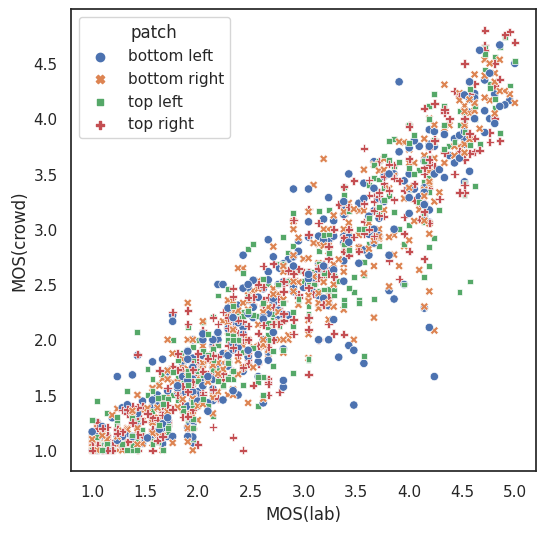

In [17]:
ddd = dr.groupby(by="stimuli_file").mean().reset_index()

ddd["patch"] = ddd["stimuli_file"].apply(lambda x: x.split("_")[-1].split(".")[0])
ddd["patch"] = ddd["patch"].apply(lambda x: label_map[x])
ddd["image_name"] = ddd["stimuli_file"].apply(lambda x: "_".join(os.path.basename(x).split("_")[0:-1])).copy()

ddd = pd.merge(ddd, dmos)

d(ddd)

sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")
ax = sns.scatterplot(x="mos", y="crowd", data=ddd, hue="patch", style="patch")
ax.set_xlabel("MOS(lab)")
ax.set_ylabel("MOS(crowd)")
save_fig(ax, "scatter_per_patch")

In [18]:
dcorrs = pd.DataFrame(corrs)
d(dcorrs.sort_values(by="pearson", ascending=False))
print(dcorrs.sort_values(by="pearson", ascending=False).round(3).to_latex(index=False))

,patch,pearson,spearman,kendall,rmse
3,top right,0.953749,0.954160,0.824275,0.527274
1,bottom right,0.946299,0.950008,0.811751,0.550834
2,top left,0.940818,0.947419,0.806782,0.565355
0,bottom left,0.933127,0.934063,0.794272,0.567055


\begin{tabular}{lrrrr}
\toprule
       patch &  pearson &  spearman &  kendall &  rmse \\
\midrule
   top right &    0.954 &     0.954 &    0.824 & 0.527 \\
bottom right &    0.946 &     0.950 &    0.812 & 0.551 \\
    top left &    0.941 &     0.947 &    0.807 & 0.565 \\
 bottom left &    0.933 &     0.934 &    0.794 & 0.567 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_317857/575548307.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dcorrs.sort_values(by="pearson", ascending=False).round(3).to_latex(index=False))


/tmp/ipykernel_317857/3730321736.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dvar_r = dr.groupby(by="image_name").std().reset_index()[["image_name", "crowd"]]


,image_name,std_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,0.980620
1,BennuProRes4444.mov_1frame_crf_06_height_0592,0.821544
2,BennuProRes4444.mov_1frame_crf_08_height_0448,0.790431
3,BennuProRes4444.mov_1frame_crf_13_height_0304,0.719435
4,BennuProRes4444.mov_1frame_crf_21_height_0320,0.627076


/tmp/ipykernel_317857/3730321736.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dvar_r["std_crowd"])


<AxesSubplot: xlabel='std_crowd', ylabel='Density'>

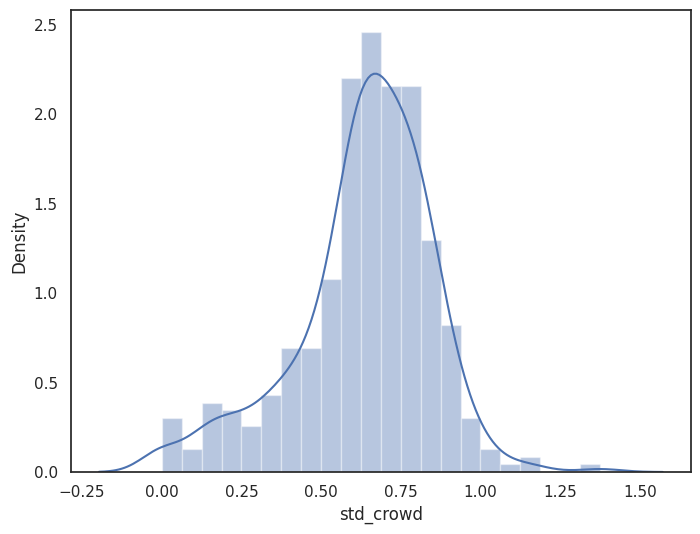

In [19]:

sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("white")
dvar_r = dr.groupby(by="image_name").std().reset_index()[["image_name", "crowd"]]
dvar_r = dvar_r.rename(columns={"crowd": "std_crowd"})
d(dvar_r.head())

sns.distplot(dvar_r["std_crowd"])

/tmp/ipykernel_317857/3610935911.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dvar_r_pp = dr.groupby(by="stimuli_file").std().reset_index()[["stimuli_file", "crowd"]]


,stimuli_file,std_crowd_per_patch
0,./images/BennuProRes4444.mov_1frame_crf_03_hei...,1.013794
1,./images/BennuProRes4444.mov_1frame_crf_03_hei...,0.910259
2,./images/BennuProRes4444.mov_1frame_crf_03_hei...,0.967418
3,./images/BennuProRes4444.mov_1frame_crf_03_hei...,0.857493
4,./images/BennuProRes4444.mov_1frame_crf_06_hei...,0.662371


/tmp/ipykernel_317857/3610935911.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dvar_r_pp["std_crowd_per_patch"])


<AxesSubplot: xlabel='std_crowd_per_patch', ylabel='Density'>

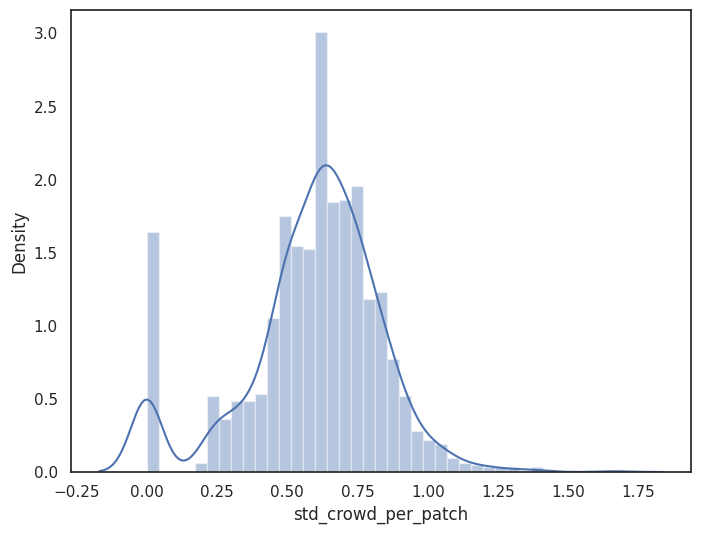

In [20]:


dvar_r_pp = dr.groupby(by="stimuli_file").std().reset_index()[["stimuli_file", "crowd"]]
dvar_r_pp = dvar_r_pp.rename(columns={"crowd": "std_crowd_per_patch"})
d(dvar_r_pp.head())

sns.distplot(dvar_r_pp["std_crowd_per_patch"])

,user_ID,stimuli_ID,stimuli_file,rating_type,crowd,timestamp,c,image_name,patch
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845,1,Sparks_20170214.mxf_1frame_crf_06_height_0720,tr
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659,1,NTIA_4K_Vignette_1_Violin-422p-8bit-60fps-4096...,tr
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806,1,classroom.mkv_1frame_crf_12_height_0368,bl
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894,1,asian_fusion_harmonic.mkv_1frame_crf_08_height...,br
5,1,1011,./images/monkeys_harmonic.mkv_1frame_crf_02_he...,acr,4,2020-03-27 13:51:25 718980,1,monkeys_harmonic.mkv_1frame_crf_02_height_1504,br


,image_name,c,i
190,american_football_harmonic.mkv_1frame_crf_07_h...,46,0
211,asian_fusion_harmonic.mkv_1frame_crf_08_height...,49,1
90,Netflix_BarScene_4096x2160_60fps_10bit_420.y4m...,49,2
91,Netflix_BarScene_4096x2160_60fps_10bit_420.y4m...,51,3
114,Netflix_DrivingPOV_4096x2160_60fps_10bit_420.y...,51,4


Text(0, 0.5, '#ratings')

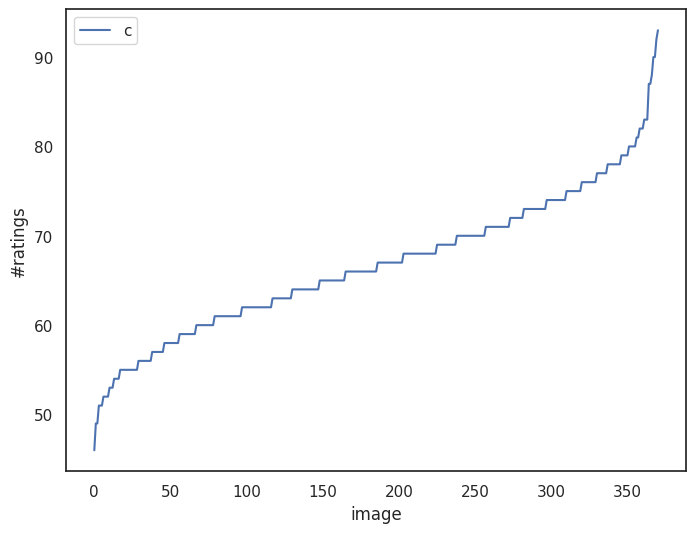

In [21]:
d(dr.head())
ddd = dr.groupby(by="image_name").count().reset_index()

ddd = ddd[["image_name", "c"]]
ddd = ddd.sort_values(by="c")
ddd["i"] = range(len(ddd))

d(ddd.head())
ax = ddd.plot(x="i", y="c", kind="line")
ax.set_xlabel("image")
ax.set_ylabel("#ratings")


/tmp/ipykernel_317857/3969118993.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dr.groupby("image_name").count().reset_index()["c"])


<AxesSubplot: xlabel='c', ylabel='Density'>

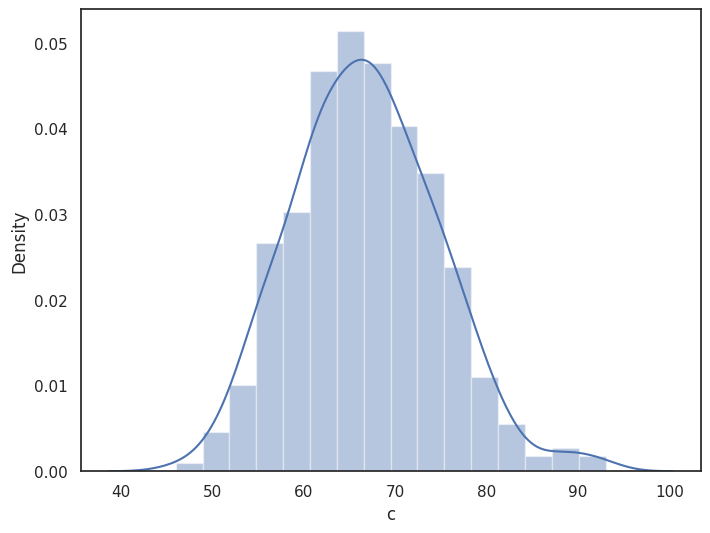

In [22]:
sns.distplot(dr.groupby("image_name").count().reset_index()["c"])

In [23]:
d(dmerged.head())
print(len(dmerged))

,image_name,mos,ci,std,mean_crowd,std_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424,2.763636,0.980620
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881,2.661765,0.821544
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,0.601585,2.406780,0.790431
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,0.601585,1.945946,0.719435
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,0.478091,1.689655,0.627076


371


In [24]:
dmerged["mos"].max()

5.0

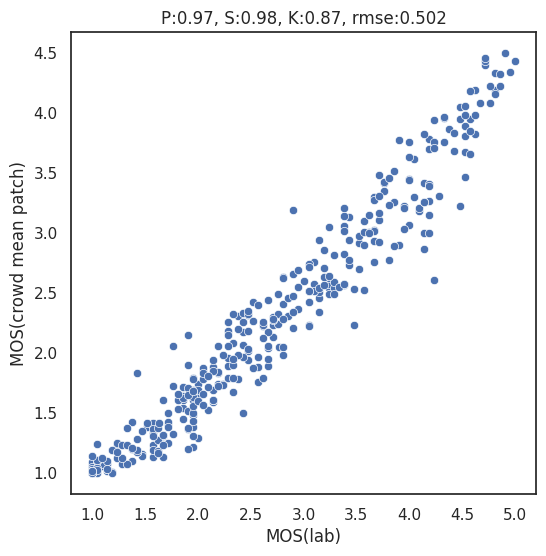

In [25]:
rmse = ((dmerged["mos"] - dmerged["mean_crowd"]) ** 2).mean() ** .5 
p = dmerged[["mos", "mean_crowd"]].corr(method="pearson")["mos"][1].round(2)
s = dmerged[["mos", "mean_crowd"]].corr(method="spearman")["mos"][1].round(2)
k = dmerged[["mos", "mean_crowd"]].corr(method="kendall")["mos"][1].round(2)

corr = "P:{}, S:{}, K:{}, rmse:{}".format(
    p,
    s,
    k,
    rmse.round(3)
)


sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("white")

#dmerged.plot(x="mos", y="mean_crowd", kind="scatter", figsize=(6,6), title=corr)

ax = sns.scatterplot(x="mos", y="mean_crowd", data=dmerged)
ax.set_title(corr)
ax.set_ylabel("MOS(crowd mean patch)")
ax.set_xlabel("MOS(lab)")


save_fig(ax, "mean_patch_mos")

In [26]:
d(dmerged.head())
dmerged.to_csv("mean_crowd_mos.csv", index=False)

,image_name,mos,ci,std,mean_crowd,std_crowd
0,BennuProRes4444.mov_1frame_crf_03_height_0864,3.095238,0.699565,0.768424,2.763636,0.980620
1,BennuProRes4444.mov_1frame_crf_06_height_0592,2.904762,0.568885,0.624881,2.661765,0.821544
2,BennuProRes4444.mov_1frame_crf_08_height_0448,2.809524,0.547677,0.601585,2.406780,0.790431
3,BennuProRes4444.mov_1frame_crf_13_height_0304,2.476190,0.547677,0.601585,1.945946,0.719435
4,BennuProRes4444.mov_1frame_crf_21_height_0320,2.142857,0.435249,0.478091,1.689655,0.627076


In [27]:
dcorrs = pd.DataFrame(corrs).append([{
    "patch": "mean",
    "pearson": p,
    "kendall": k,
    "spearman": s,
    "rmse": rmse
}])
d(dcorrs.sort_values(by="pearson", ascending=False))
print(dcorrs.sort_values(by="pearson", ascending=False).round(3).to_latex(index=False))

/tmp/ipykernel_317857/3560730090.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dcorrs = pd.DataFrame(corrs).append([{


,patch,pearson,spearman,kendall,rmse
0,mean,0.970000,0.980000,0.870000,0.501863
3,top right,0.953749,0.954160,0.824275,0.527274
1,bottom right,0.946299,0.950008,0.811751,0.550834
2,top left,0.940818,0.947419,0.806782,0.565355
0,bottom left,0.933127,0.934063,0.794272,0.567055


\begin{tabular}{lrrrr}
\toprule
       patch &  pearson &  spearman &  kendall &  rmse \\
\midrule
        mean &    0.970 &     0.980 &    0.870 & 0.502 \\
   top right &    0.954 &     0.954 &    0.824 & 0.527 \\
bottom right &    0.946 &     0.950 &    0.812 & 0.551 \\
    top left &    0.941 &     0.947 &    0.807 & 0.565 \\
 bottom left &    0.933 &     0.934 &    0.794 & 0.567 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_317857/3560730090.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(dcorrs.sort_values(by="pearson", ascending=False).round(3).to_latex(index=False))


In [28]:
dmmm = df[df["rating"] != -1].copy()
d(dmmm.head())
dmr = dmmm.groupby(by="stimuli_file").mean().reset_index()[["stimuli_file", "rating"]].copy()
dstdr = dmmm.groupby(by="stimuli_file").std().reset_index()[["stimuli_file", "rating"]].copy()
dstdr = dstdr.rename(columns={
    "rating": "std"
})

d(dstdr)
dm = pd.merge(dmr, dstdr)
d(dm.head())

,user_ID,stimuli_ID,stimuli_file,rating_type,rating,timestamp
1,1,688,./images/Sparks_20170214.mxf_1frame_crf_06_hei...,acr,2,2020-03-27 13:51:10 959845
2,1,309,./images/NTIA_4K_Vignette_1_Violin-422p-8bit-6...,acr,1,2020-03-27 13:51:14 468659
3,1,152,./images/classroom.mkv_1frame_crf_12_height_03...,acr,2,2020-03-27 13:51:18 371806
4,1,1161,./images/asian_fusion_harmonic.mkv_1frame_crf_...,acr,1,2020-03-27 13:51:21 653894
5,1,1011,./images/monkeys_harmonic.mkv_1frame_crf_02_he...,acr,4,2020-03-27 13:51:25 718980


/tmp/ipykernel_317857/888788573.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dmr = dmmm.groupby(by="stimuli_file").mean().reset_index()[["stimuli_file", "rating"]].copy()
/tmp/ipykernel_317857/888788573.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dstdr = dmmm.groupby(by="stimuli_file").std().reset_index()[["stimuli_file", "rating"]].copy()


,stimuli_file,std
0,./images/BennuProRes4444.mov_1frame_crf_03_hei...,1.013794
1,./images/BennuProRes4444.mov_1frame_crf_03_hei...,0.910259
2,./images/BennuProRes4444.mov_1frame_crf_03_hei...,0.967418
3,./images/BennuProRes4444.mov_1frame_crf_03_hei...,0.857493
4,./images/BennuProRes4444.mov_1frame_crf_06_hei...,0.662371
...,...,...
1479,./images/weapon8k-standard-60fps-12to1redcode_...,0.550482
1480,./images/weapon8k-standard-60fps-12to1redcode_...,0.383482
1481,./images/weapon8k-standard-60fps-12to1redcode_...,0.316228
1482,./images/weapon8k-standard-60fps-12to1redcode_...,0.702500


,stimuli_file,rating,std
0,./images/BennuProRes4444.mov_1frame_crf_03_hei...,2.555556,1.013794
1,./images/BennuProRes4444.mov_1frame_crf_03_hei...,3.400000,0.910259
2,./images/BennuProRes4444.mov_1frame_crf_03_hei...,2.538462,0.967418
3,./images/BennuProRes4444.mov_1frame_crf_03_hei...,2.500000,0.857493
4,./images/BennuProRes4444.mov_1frame_crf_06_hei...,2.434783,0.662371


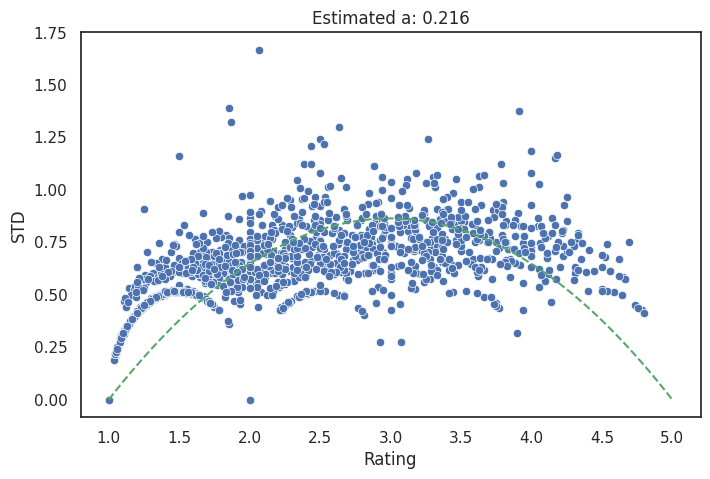

In [29]:
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})
sns.set_style("white")
# draw a SOS plot
# read: http://materials.dagstuhl.de/files/15/15022/15022.TobiasHo%C3%9Ffeld1.Preprint.pdf
# for a more detailed description of SOS plots

ax = sns.scatterplot(x="rating", y="std", data=dm)

#, with the y=(x-1)*(x-5)* a interpolated function 

x_data = dm["rating"].values
y_data = dm["std"].replace(np.NaN, 0).values

from scipy.optimize import curve_fit

def fitting_function(x, a):
    return (x - 1) * (x - 5) * (-a)

popt, pcov = curve_fit(fitting_function, x_data, y_data) 


x = np.linspace(1, 5, 100)
ax.plot(x, fitting_function(x, *popt), 'g--')
ax.set_title(f"Estimated a: {popt[0].round(3)}")
ax.set_xlabel("Rating")
ax.set_ylabel("STD")

save_fig(ax, "sos")
